# Tutorial
I’m going to explore the practical usages of topic model using the Gensim Library, such as finding structures for unknown datasets, classifying unlabeled data as well as improving accuracy of supervised learning.

## Introduction
This tutorial will introduce you several practical ways of using topic models with **Gensim Library**. In this tutorial I mainly focus on 2 kinds of topic models: *Latent Semantic Indexing (LSI)* and *Latent Dirichlet Allocation (LDA)*. In different cases, topic models can have different functionalities. Throughout this tutorial, you will learn how to use topic models to find structure for unknown datasets, classifying unlabeled data as well as improving the accuracy of supervised learning. Besides, in order to have a better views to the results, this tutorial also introduces some data visualization methods for reviewing topic models. 

We will cover the following topics in this tutorial:
- [Installing the libraries](#Installing-the-libraries)
- [Processing text](#Processing-text)
- [Visualizing Topic models](#Visualizing-Topic-models)
    - [Top words of topics](#Visualize-top-words-of-topics)
    - [Topic shares stack bar](#Stack-Bar)
    - [Topic shares heatmap](#Heatmap)
- [Train Topic Models](#Train-Topic-Models)
    - [Training LSI model](#Training-LSI-model)
    - [Training LDA model](#Training-LDA-model)
    - [Comparation](#Comparation)
- [Finding structures of unknown text](#Finding-structures-of-unknown-text)
- [Classifying unlabeled data](#Classifying-unlabeled-data)
    - [Larger topic number](#Larger-topic-number)
    - [Larger dataset](#Larger-dataset)
    - [Summary](#Summary)
- [Classifying labeled data](#Classifying-labeled-data)
- [Conclusion](#Conclusion)
- [Reference](#Reference)

## Installing the libraries

Before getting started, you'll need to install the various libraries that we will use.  You can install Gensim, and NLTK using `pip`:

    $ pip3 install --upgrade gensim

    $ pip3 install -U nltk

When doing the examples, you might also need to use scikit-learn:

    $ pip3 install -U scikit-learn

In [1]:
import gensim,nltk,sklearn,time,random,numpy as np,matplotlib.pyplot as plt

## Processing text
Here we use the [20 newsgroups text dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html) from sklearn datasets. We also use the same processing method as homework-3. Additionally, we also remove all the stopwords as well as rarewords in the document. 

In [2]:
from sklearn.datasets import fetch_20newsgroups
from text_process import process, tokenize, remove_stopwords

The 20 newsgroups dataset comprises around 18000 newsgroups posts on 20 topics split in two subsets: one for training and the other one for testing. Since for basic topic models there is no better way to truly evaluate the topics than manually examine the results and see whether they made sense. So here I use both training and testing sets for generating the topic model. Since it might take longer time to generate the topic model for all of the data, here I randomly sample 1000 documents from all 18846 documents.

In [3]:
newsgroups = fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'))
data = newsgroups.data
data_category = list(newsgroups.target)
categories = newsgroups.target_names

In [30]:
start = time.time()
docs_raw = [tokenize(doc) for doc in newsgroups.data]
docs = remove_stopwords(docs_raw)
k = 1000
sample_idxs = random.sample(range(len(docs)), k)  # 1000 samples from docs in order to do quick modeling
docs_sample = []
docs_raw_sample = []
for idx in sample_idxs:
    docs_sample.append(docs[idx]) 
    docs_raw_sample.append(docs_raw[idx])
end = time.time()
print("Processing time: " + str(end - start))

Processing time: 67.22969269752502


In order to generate topic models, we have to create the term dictionary of the chosen corpus and converting the corpus into document term matrix. 

In [31]:
# Creating the term dictionary of our corpus, where every unique term is assigned an index. 
dictionary_all = gensim.corpora.Dictionary(docs)
dictionary_sample = gensim.corpora.Dictionary(docs_sample)

# Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
doc_term_matrix_all = [dictionary_all.doc2bow(doc) for doc in docs]
doc_term_matrix_sample = [dictionary_sample.doc2bow(doc) for doc in docs_sample]

# Use tf-idf model to help get each document's topic
tfidf = gensim.models.TfidfModel(doc_term_matrix_sample)
corpus_tfidf = tfidf[doc_term_matrix_sample]

## Visualizing Topic models
Topic models reveal the distribution of topics in each documents which can be hard to present to the users. So finding some ways to visualize the result from topic models is very important. Here I'll introduce you 3 useful methods to present topic models. In this section I just present the code of the methods. I'll present the plot results in later sections. 

### Visualize top words of topics
After generating the topic model, each topic will have each own significant words. Getting the most significant words in each topic and plotting them in a table can help us better understanding the '*meaning*' of each topic. So here I use the belowing method to visualize each topic's top words<br>
In the plotting table, the size of each words represents the significance of the word in relative topic. (The significance value can be negative in LSI, which means the missing of that word is important for this topic). In the table, the *'+'* means positive significance value, while the *'-'* represents negative. <br>
See example in [1](#Visualize-top-words-of-topics-for-LSI) and [2](#Visualize-top-words-of-topics-for-LDA)

In [69]:
def plot_topicwords(num_top_words, topic_words, w, h, fontsize_base):
    import matplotlib as mpl 
    mpl.rcParams['figure.figsize'] = (w,h)
    for t in range(topic_num):
        plt.subplot(6, 5, t + 1)  # plot numbering starts with 1
        plt.ylim(0, num_top_words + 1)  # stretch the y-axis to accommodate the words
        plt.xticks([])  # remove x-axis markings ('ticks')
        plt.yticks([]) # remove y-axis markings ('ticks')
        plt.title('Topic #{}'.format(t))
        top_words = [item[0] for item in topic_words[t][1]]
        top_words_shares = [float(item[1]) for item in topic_words[t][1]]
        for i, (word, share) in enumerate(zip(top_words, top_words_shares)):
            if share < 0:
                word = '- ' + word
            else:
                word = '+ ' + word
            plt.text(0.1, num_top_words - 0.7 - i, word, fontsize=min(fontsize_base*abs(share), 40))
    plt.tight_layout()
    plt.show()

### Visualize topic shares in documents
We are also very interested in the distribution of topics in documents. Here I introduce you 2 methods to reveal the distribution:
+ Use Stacked bar to present topic shares.
+ Use Heatmap to show each topic's contribution

#### Stack Bar
Use a stack bar to plot the percentage of topics for all the chosen documents. <br>
See examples in [1](#Visualize-topic-shares-using-stack-bar-for-LSI) and [2](#Visualize-topic-shares-using-stack-bar-for-LDA)

In [67]:
def plot_topic_share(docs_topic, topic_num, w, h):
    import matplotlib as mpl
    plots = []
    N = len(docs_topic)
    height_cumulative = np.zeros(N)
    ind = np.arange(N)
    width = 0.2
    
    tmp = [[abs(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    for val_ls in tmp:
        val_sum = sum(val_ls)
        for i in range(len(val_ls)):
            val_ls[i] = val_ls[i] / val_sum
    
    doctopic = np.array(tmp)
    
    mpl.rcParams['figure.figsize'] = (w,h)
    
    for k in range(topic_num):
        color = plt.cm.nipy_spectral(k/topic_num, 1)
        if k == 0:
            p = plt.bar(ind, doctopic[:, k], width, color=color)
        else:
            p = plt.bar(ind, doctopic[:, k], width, bottom=height_cumulative, color=color)
        height_cumulative += doctopic[:, k]
        plots.append(p)
    
    plt.ylim((0, 1)) 
    plt.ylabel('Topics')
    plt.title('Topics in docs')
    
    
    plt.xticks(ind+width/2, list(range(N)))
    plt.yticks(np.arange(0, 1, 10))
    
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    plt.legend([p[0] for p in plots], topic_labels)
    plt.show()

#### Heatmap
Use a heatmap to show the value of topics in all the chosen map.<br>
See examples in [1](#Visualize-topic-shares-using-Heatmap-for-LSI) and [2](#Visualize-topic-shares-using-Heatmap-for-LDA)

In [68]:
def plot_topic_val(docs_topic, topic_num, width, height):
    import matplotlib as mpl
    tmp = [[(val[1]) for val in doc_topic] for doc_topic in docs_topic]
    doctopic = np.array(tmp)
    topic_labels = ['Topic #{}'.format(k) for k in range(topic_num)]
    
    plt.pcolor(doctopic, norm=None, cmap='nipy_spectral')
    mpl.rcParams['figure.figsize'] = (width, height)
    
    plt.yticks(np.arange(doctopic.shape[0])+0.5, list(range(doctopic.shape[0])));
    plt.xticks(np.arange(doctopic.shape[1])+0.5, topic_labels);
    plt.gca().invert_yaxis()
    plt.xticks(rotation=90)
    plt.colorbar(cmap='nipy_spectral')
    plt.tight_layout()
    plt.show()

## Train Topic Models

### Training LSI model
With all the processed data above, now we can use the Gensim's Lsimodel to train a LSI model. Here we also present the training result via all the visualizing methods provided above. <br>
We have to construct a LsiModel object using gensim.models.lsimodel.LsiModel:<br>


Parameters: 
+ corpus: corpus used to generate topic model
+ num_topics: number of assuming topics
+ id2word: ID to word mapping

In [32]:
topic_num = 30
Lsi = gensim.models.lsimodel.LsiModel
lsimodel = Lsi(corpus=doc_term_matrix_sample, num_topics=topic_num, id2word = dictionary_sample)

And we also get the significant words in each topics using the built-in function **show_topics**. <br>
And we also get the distribution of topics in each documents via the previous tf-idf model. 

In [33]:
topic_words = lsimodel.show_topics(formatted=False)
corpus_lsi = lsimodel[corpus_tfidf]

#### Visualize top words of topics for LSI
By visualizing the top words of topics from LSI model, we can easily find out: (Each time might be different)
+ Topic #2 and #4 might talks about something related with computer. 
+ Topic #3 might talks about something related with space.
+ Topic #8 and #16 might talks about something related with religion.
+ Topic #13 might talks about something related with country.

...<br>
Some topics make sense.

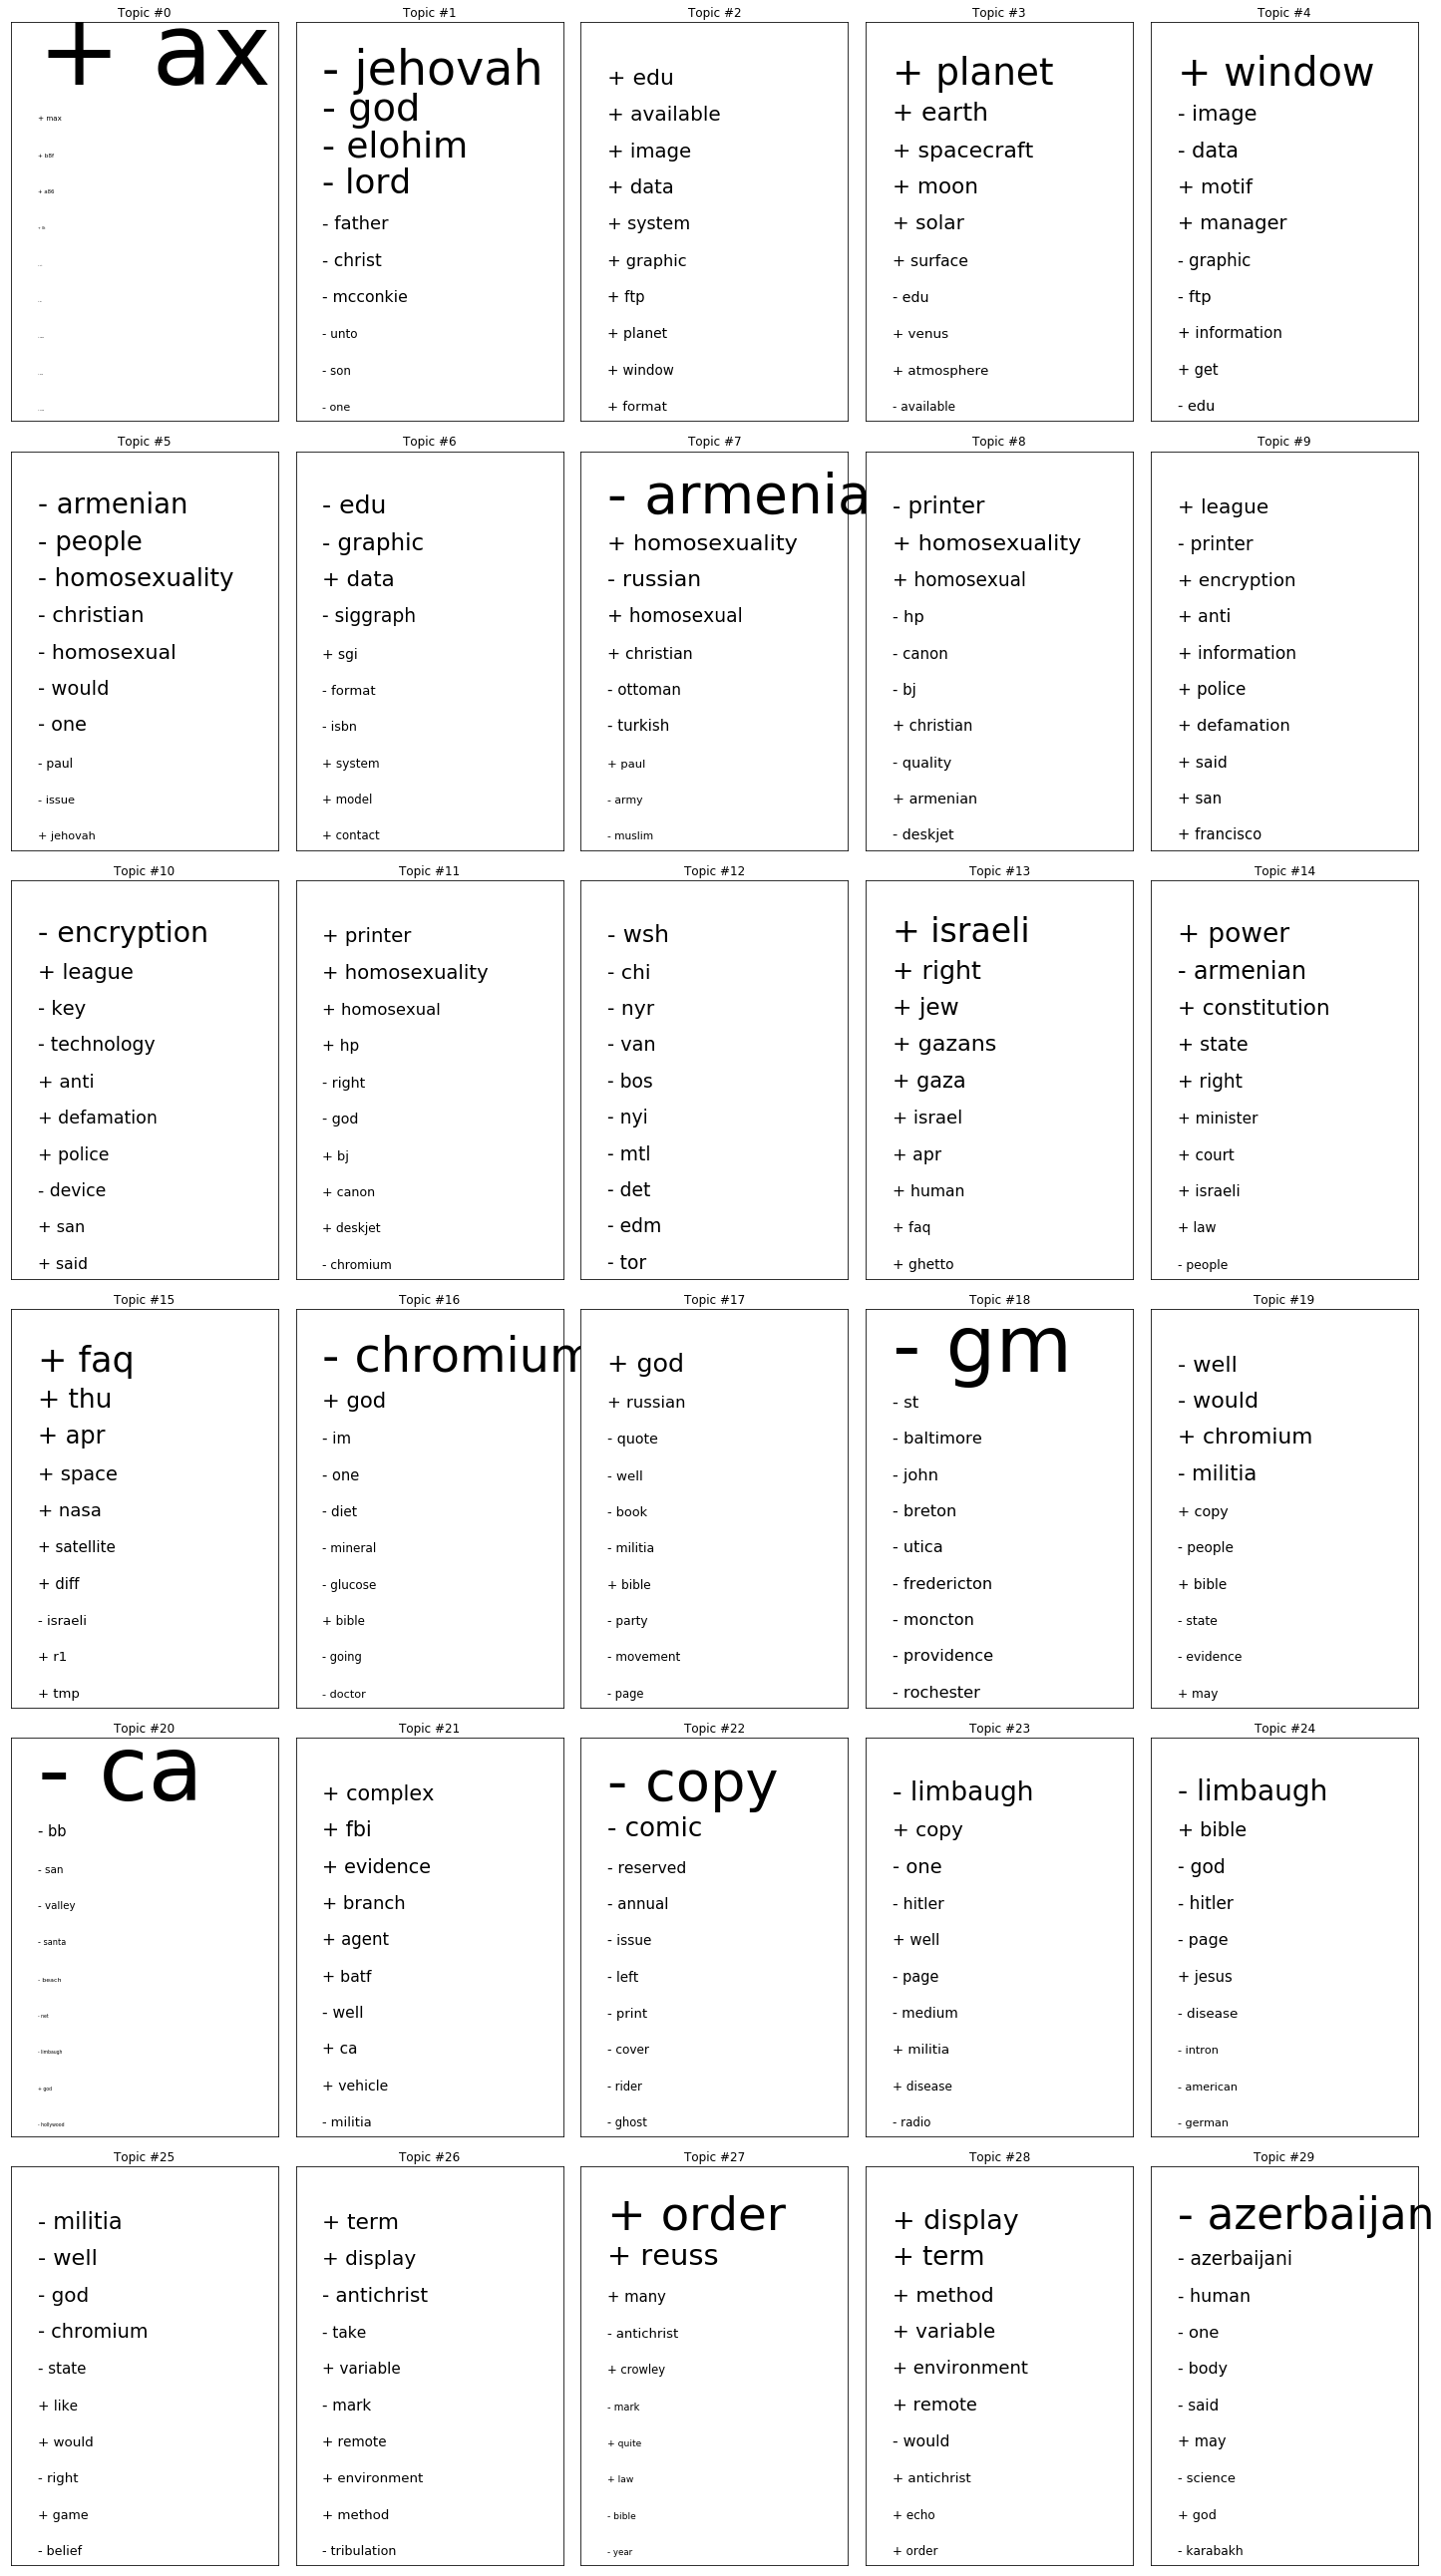

In [34]:
plot_topicwords(10, topic_words, 20, 36, 100)

#### Visualize topic shares using stack bar for LSI
We can see that the topic shares of each document differs any others.  

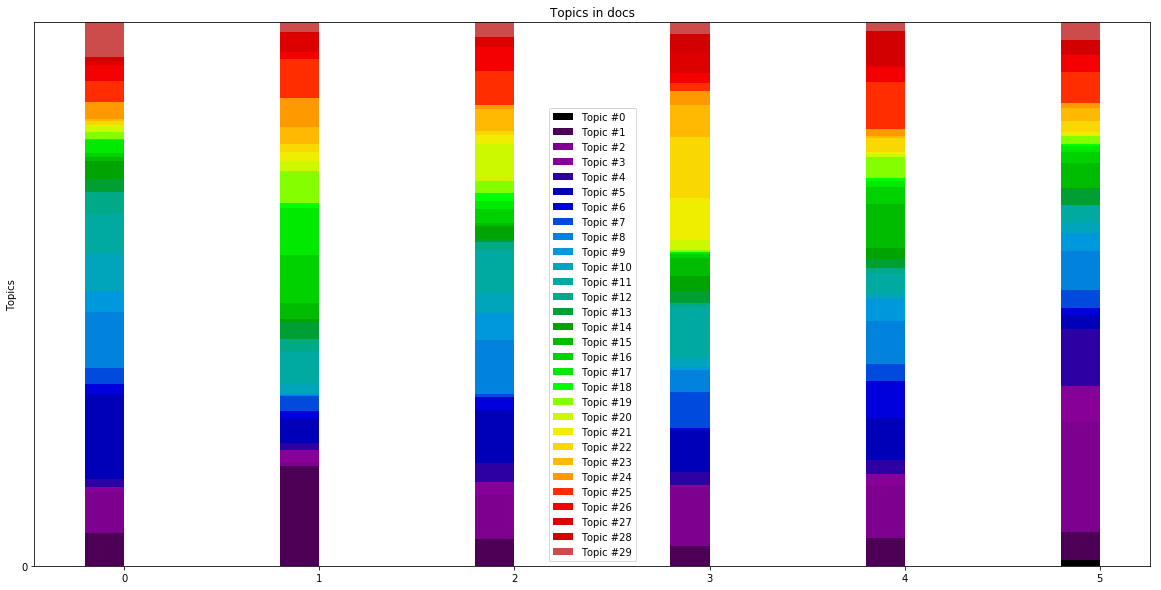

In [35]:
plot_topic_share(corpus_lsi[:6], topic_num, 20, 10)

#### Visualize topic shares using Heatmap for LSI
Topic shares of each document differs any others.

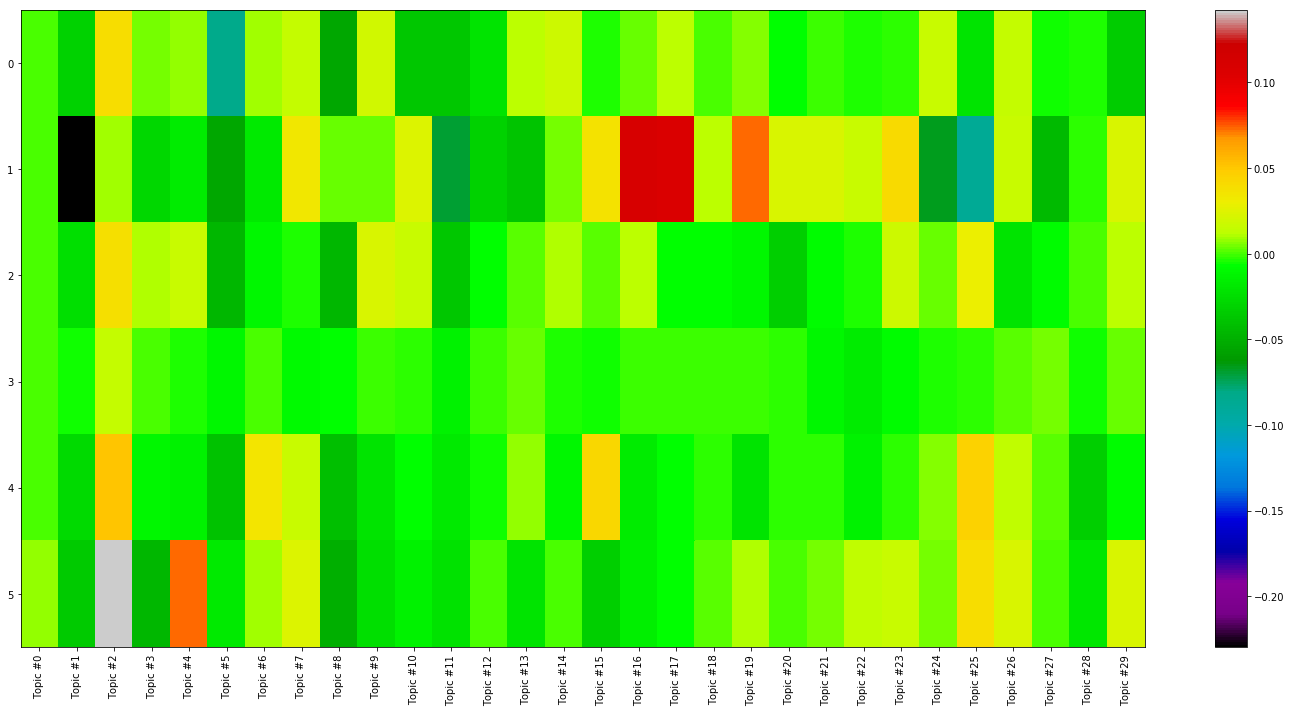

In [36]:
plot_topic_val(corpus_lsi[:6], topic_num, 20, 10)

## Training LDA model
We can also use the Gensim's LdaModel to train a LDA model. 
We have to construct a LsiModel object using gensim.models.ldamodel.LdaModel:

Parameters:

+ corpus: corpus used to generate topic model
+ num_topics: number of assuming topics
+ id2word: ID to word mapping
+ passes: times of passes over the supplied corpus
+ minimum_probability: choose to be small since I don't want to ignore some small-value topics. (which might cause trouble when visualizing topic shares in documents)

In [37]:
Lda = gensim.models.ldamodel.LdaModel

# Running and Trainign LDA model on the document term matrix.
ldamodel = Lda(doc_term_matrix_sample, num_topics=topic_num, 
               id2word = dictionary_sample, passes=50, minimum_probability = 0.0001)

We also get the significant words in each topics using the built-in function show_topics. (unlike LSI, LDA have to input number of topics, otherwise it just output top-10 topics) <br>
And we also get the distribution of topics in each documents via the get_document_topics method.

In [38]:
topic_words_lda = ldamodel.show_topics(num_topics=topic_num, formatted=False)
corpus_lda = ldamodel.get_document_topics(corpus_tfidf, minimum_phi_value=1e-10)

#### Visualize top words of topics for LDA
By visualizing the top words of topics from LDA model, we can easily find out:
+ Topic #12 and #21 might be related with religion. 
+ Topic #10 might be related with space.
+ Topic #20 might be related with name.
+ Topic #18, #22, #27, #28 might be different aspect of computer.

...<br>
LDA topics make more sense than LSI.

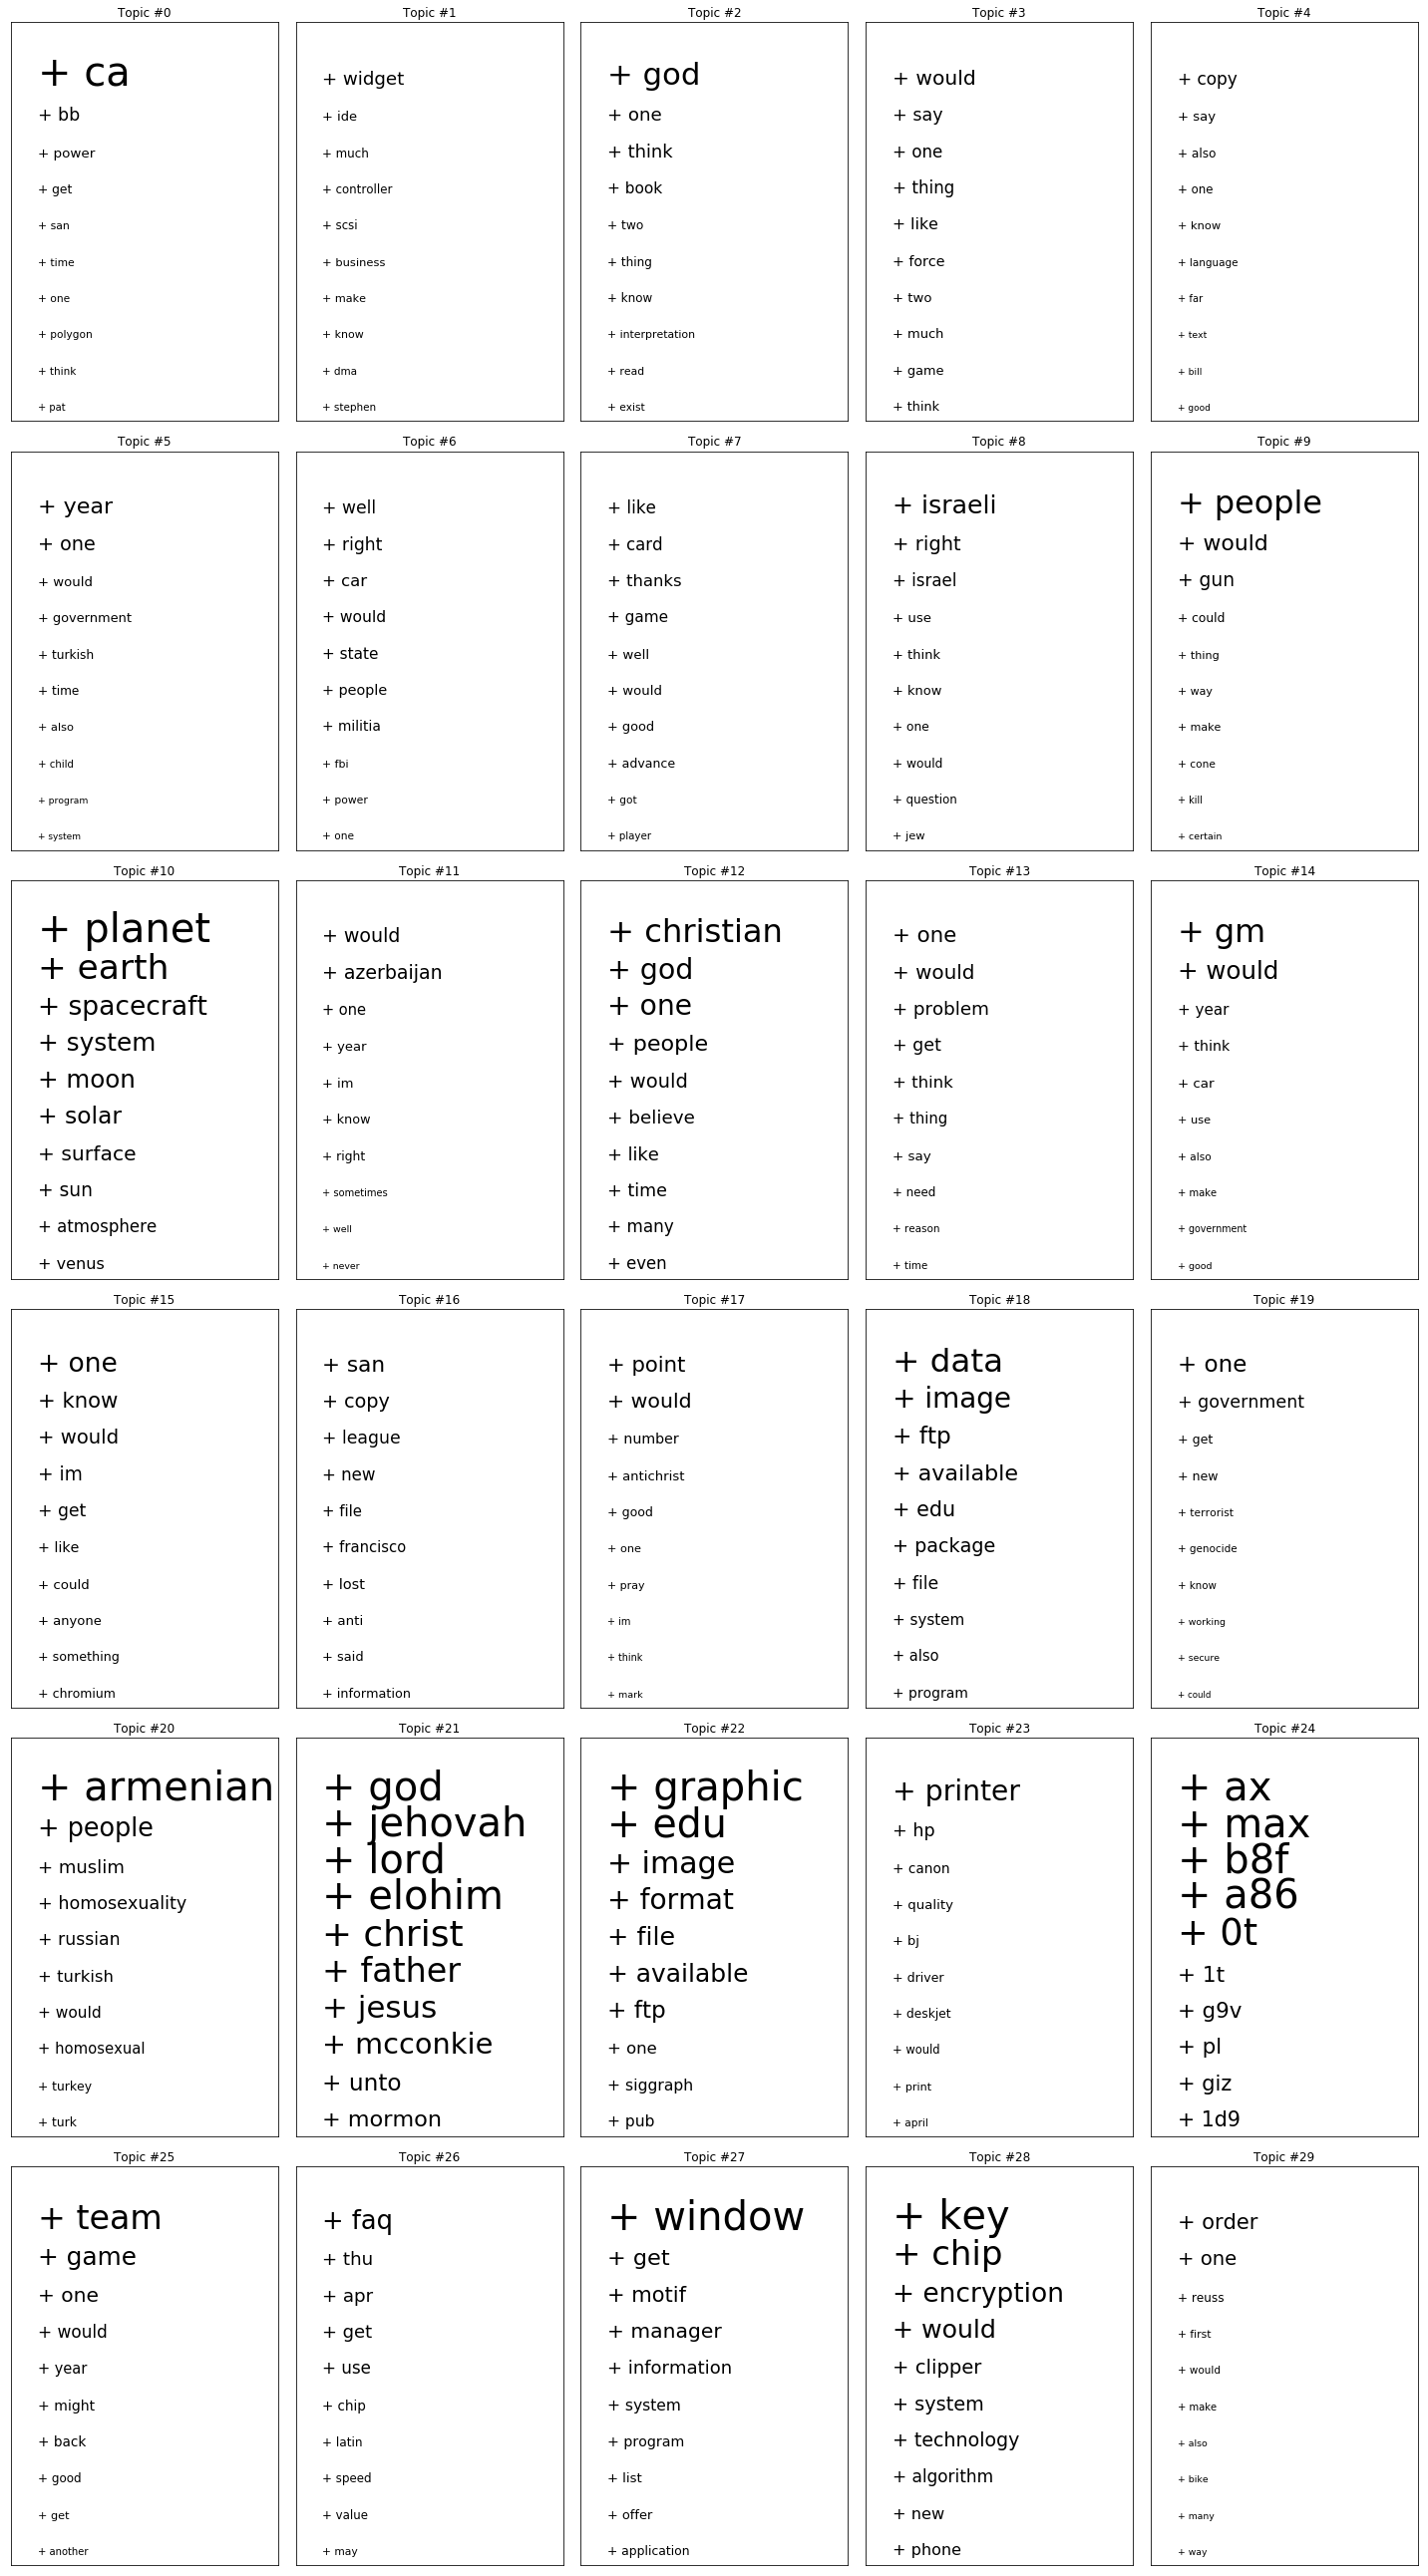

In [53]:
plot_topicwords(10, topic_words_lda, 20, 36, 2500)

#### Visualize topic shares using stack bar for LDA
We can see that the topic shares differs much. We can clearly point out the dominating topic in each document.

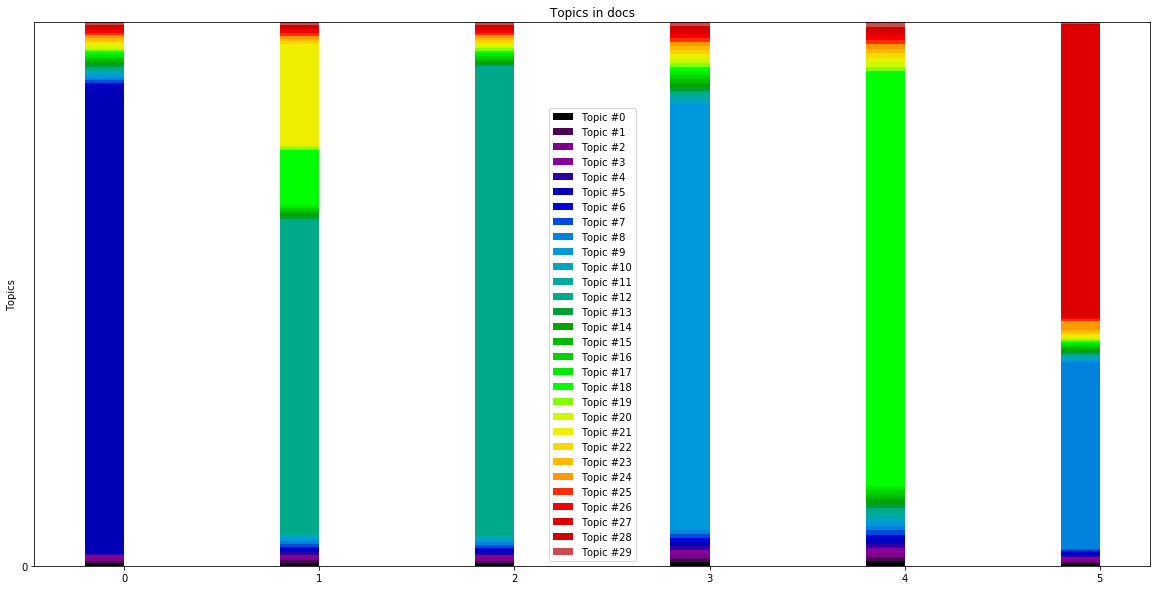

In [40]:
plot_topic_share(corpus_lda[:6], topic_num, 20, 10)

#### Visualize topic shares using Heatmap for LDA
We can clearly point out the dominating topic(s) in each document.

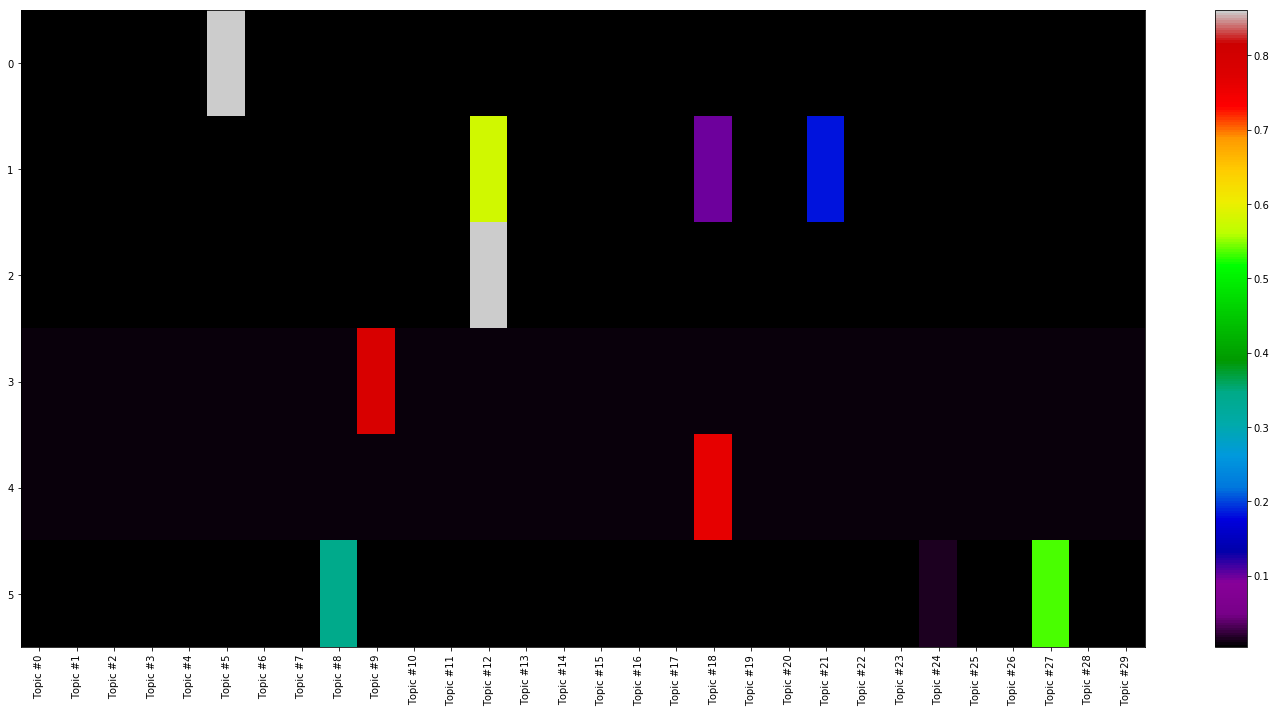

In [41]:
plot_topic_val(corpus_lda[:6], topic_num, 20, 10)

### Comparation

With the result figures above, It is clear that LDA model can get a more specific instead of diverse topic distribution. The domain topics in LDA model are easier to identify. Also the topic clusters of LDA model make more sense than LSI model. <br>
In summary, the LDA model outperforms tha LSI model. In sections below, we use **LDA model** to do all the topic model related task. 

## Finding structures of unknown text
As shown in [Training LDA model](#Training-LDA-model), we use an unknown data set to train the LDA model and get the topic distribution of each document in the data set. By summarying each topic's top words, we can figure out the approximate meaning of each topic. In this way, we can find out the structure of each unknown document. <br>
Here we take the sample model as example. (**Remember: I randomly select 1000 documents from the dataset, each time the running result may be totally different.** *Here I just take one time's result as an example.*)<br>
From [LDA heatmap figure](#Visualize-topic-shares-using-Heatmap-for-LDA), we know the second sample document is mainly about topic-12, topic-18 and topic-21. Seen from the [top-word figure](#Visualize-top-words-of-topics-for-LDA), we can make a vague conclusion that topic-12 and topic-21 are both religion related. After we print out the document text below, we find out the document is indeed religion related, which means we can use topic model to find out the structure of unknown text. We can test our observation by printing out the document's groung-truth category.

In [79]:
## print out the raw data of the second sample
print(data[sample_idxs[1]])

Although simplistic I have always liked the fact that "a Christian is one
who not only believes in God, but believes God."  After all the name was
first given externally to identify those who "preached Christ and Him
crucified" to pay the price of their rebeliion and shortcomings before
God.  God said this was His son -- I belive Him.
-- 
Scott Dittman                    email: sdittman@wlu.edu
University Registrar             talk: (703)463-8455   fax: (703)463-8024
Washington and Lee University    snail mail:  Lexington Virginia 24450


In [55]:
## Print out the ground truth of the second sample's category
print(categories[data_category[sample_idxs[1]]])

soc.religion.christian


## Classifying unlabeled data
Now we have already known how to use topic model finding structure for unknown dataset. We can go further to classify those unknown/unlabel data. <br>
We can use each document's topic distribution to generate features. And then we use Kmeans to do the classification. Finall we use ground-truth category to get precision and recall of the classification result.

In [56]:
def feature_generator_unlabeled(corpus_model):
    """
    docs_topic: gensim.interfaces.TransformedCorpus
    return: np array of each document's probability over 30 topics
    """
    feature_ls = [[item[1] for item in docs_topic] for docs_topic in corpus_model]
    return np.array(feature_ls)

In [57]:
feature = feature_generator_unlabeled(corpus_lda)

In [58]:
from sklearn.cluster import KMeans
cluster_num = 20
kmeans = KMeans(n_clusters = cluster_num, random_state=0).fit(feature)

In [59]:
# get the kmeans cluster labels of each document
predict_category = kmeans.labels_

In [60]:
# get the sample data's ground-truth category
sample_category = []
for idx in sample_idxs:
    sample_category.append(data_category[idx])

In [61]:
# get the confusion matrix
def get_confusion_mat(predict, truth):
    confusion_mat = [[0 for i in range(len(categories))] for j in range(cluster_num)] 
    for idx, val in enumerate(predict):
        true_val = truth[idx]
        confusion_mat[true_val][val] += 1
    res = np.array(confusion_mat)
    return res


To better show the result, I represent with confusion matrix and use heatmap to visualize it. Since the cluster index isn't coordinate with the category index, the confusion matrix isn't a normal one. 

In [88]:
confusion_mat = get_confusion_mat(predict_category, sample_category)

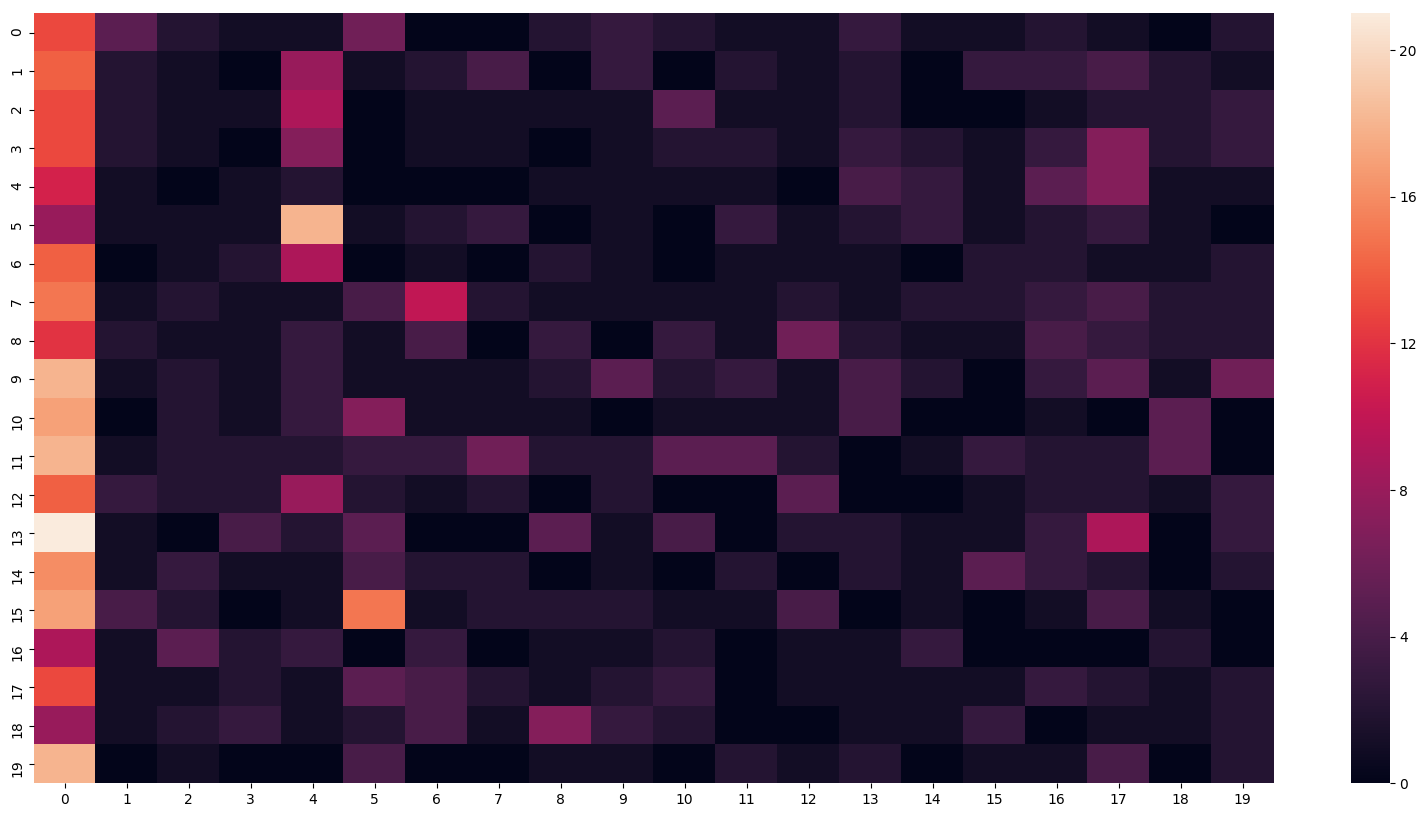

In [71]:
# Use the seaborn library to quickly plot the confusion matrix
def plot_confusion(mat):
    import seaborn as sn
    import matplotlib as mpl
    ax = sn.heatmap(mat)
    mpl.rcParams['figure.figsize'] = (20,10)
    plt.show()
plot_confusion(confusion_mat)

Since the index of each cluster in Kmeans is not the same as the index of ground-truth category, here we just consider the one with most appearance. And use that assumption to get the precision and recall.

In [72]:
## Get the precision using the confusion matrix
def get_precision(confusion):
    return confusion.max(axis=0).sum()/confusion.sum()

In [73]:
# Get the recall using the confusion matrix
def get_recall(confusion):
    return confusion.max(axis=1).sum()/confusion.sum()

In [74]:
print("The precision of the classification is: " + str(get_precision(confusion_mat)))
print("The recall of the classification is: " + str(get_recall(confusion_mat)))

The precision of the classification is: 0.149
The recall of the classification is: 0.292


We can see that the precision and recall of the result is not good. That's because it is unsurpervised learning and we barely know anything about the dataset. <br>
The bad performance of the classification might also result from:
+ the small topic number we choose. So I test using 100 topic number.
+ the small dataset we choose. So here I test in the whole dataset.

### Larger topic number
Here I set the topic number to be 100 instead of 20 and repeat the above code. Get the precision and recall. <br>
We can see that the recall improved significantly. *(From 0.29 to 0.73)* However, the precision decreases. That might be caused by the small dataset we use. Since we only have 1000 documents in the random sample data, it might have a strong bias on specific category. <br>
So we will test the whole dataset later.

In [75]:
# Running and Trainign LDA model on the document term matrix.
topic_num2 = 100
ldamodel2 = Lda(doc_term_matrix_sample, num_topics=topic_num2, 
               id2word = dictionary_sample, passes=50, minimum_probability = 0.0001)

topic_words_lda2 = ldamodel2.show_topics(num_topics=topic_num2, formatted=False)
corpus_lda2 = ldamodel2.get_document_topics(corpus_tfidf, minimum_phi_value=1e-10)

feature2 = feature_generator_unlabeled(corpus_lda2)

kmeans2 = KMeans(n_clusters = cluster_num, random_state=0).fit(feature2)

# get the kmeans cluster labels of each document
predict_category2 = kmeans2.labels_


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/gensim/models/ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


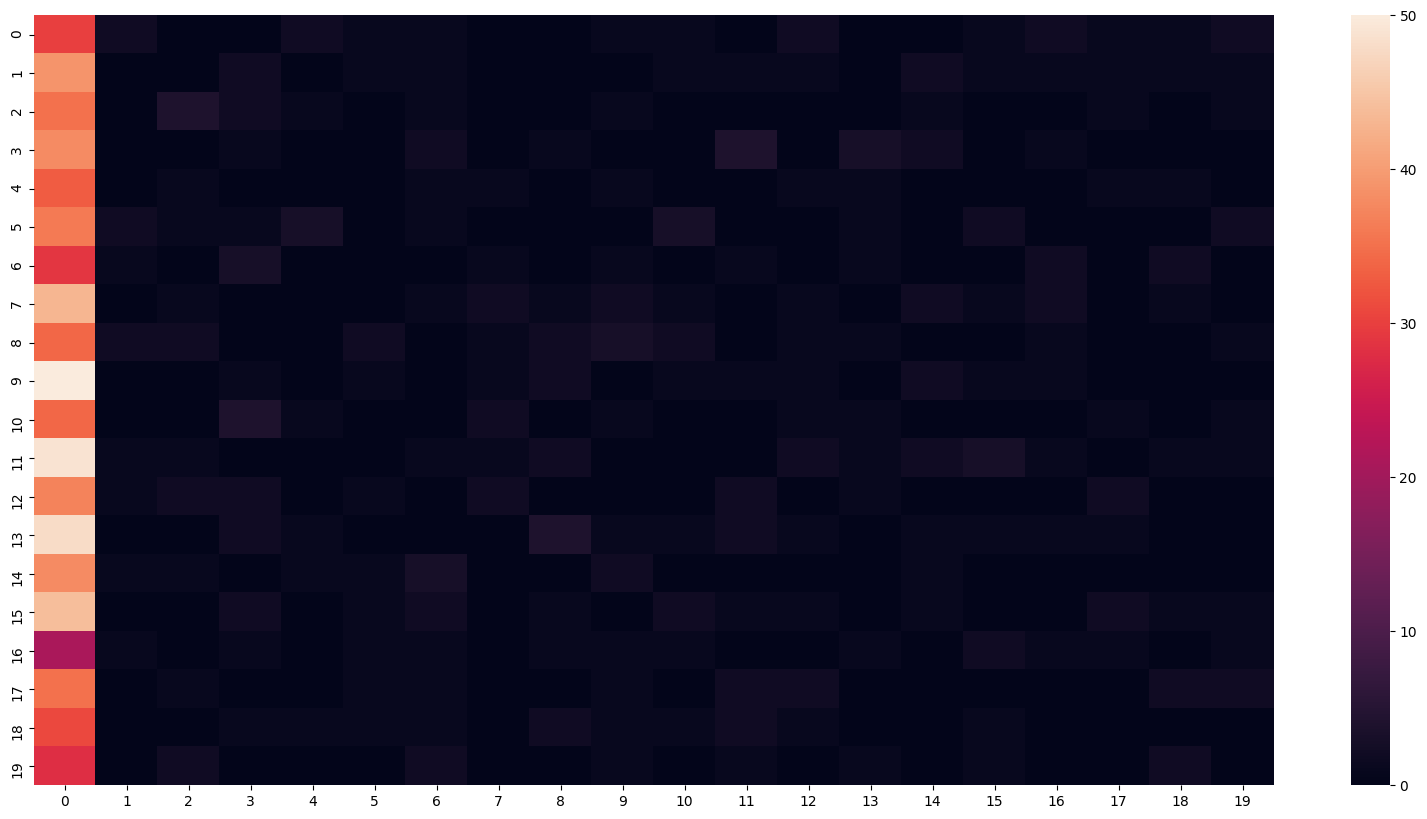

In [76]:
confusion_mat2 = get_confusion_mat(predict_category2, sample_category)
plot_confusion(confusion_mat2)

In [77]:
print("The precision of the classification is: " + str(get_precision(confusion_mat2)))

print("The recall of the classification is: " + str(get_recall(confusion_mat2)))

The precision of the classification is: 0.102
The recall of the classification is: 0.732


### Larger dataset
Here I use the whole dataset instead of the random sample one. Get the precision and recall. <br>
We can see that both precision and recall are improved significantly *(precision from 0.15 to 0.34, recall from 0.29 to 0.34)*. That means if we use larger dataset to generate topic model and do classification, we can get better result. <br>

In [78]:
## Run LDA in larger(whole) dataset 
# Running and Trainign LDA model on the document term matrix.
ldamodel_all = Lda(doc_term_matrix_all, num_topics=topic_num, 
               id2word = dictionary_all, passes=50, minimum_probability = 0.0001)

# Use tf-idf model to help get each document's topic
tfidf_all = gensim.models.TfidfModel(doc_term_matrix_all)
corpus_tfidf_all = tfidf[doc_term_matrix_all]

topic_words_lda_all = ldamodel_all.show_topics(num_topics=topic_num, formatted=False)
corpus_lda_all = ldamodel_all.get_document_topics(corpus_tfidf_all, minimum_phi_value=1e-10)

feature_all = feature_generator_unlabeled(corpus_lda_all)

kmeans_all = KMeans(n_clusters = cluster_num, random_state=0).fit(feature_all)

# get the kmeans cluster labels of each document
predict_category_all = kmeans_all.labels_

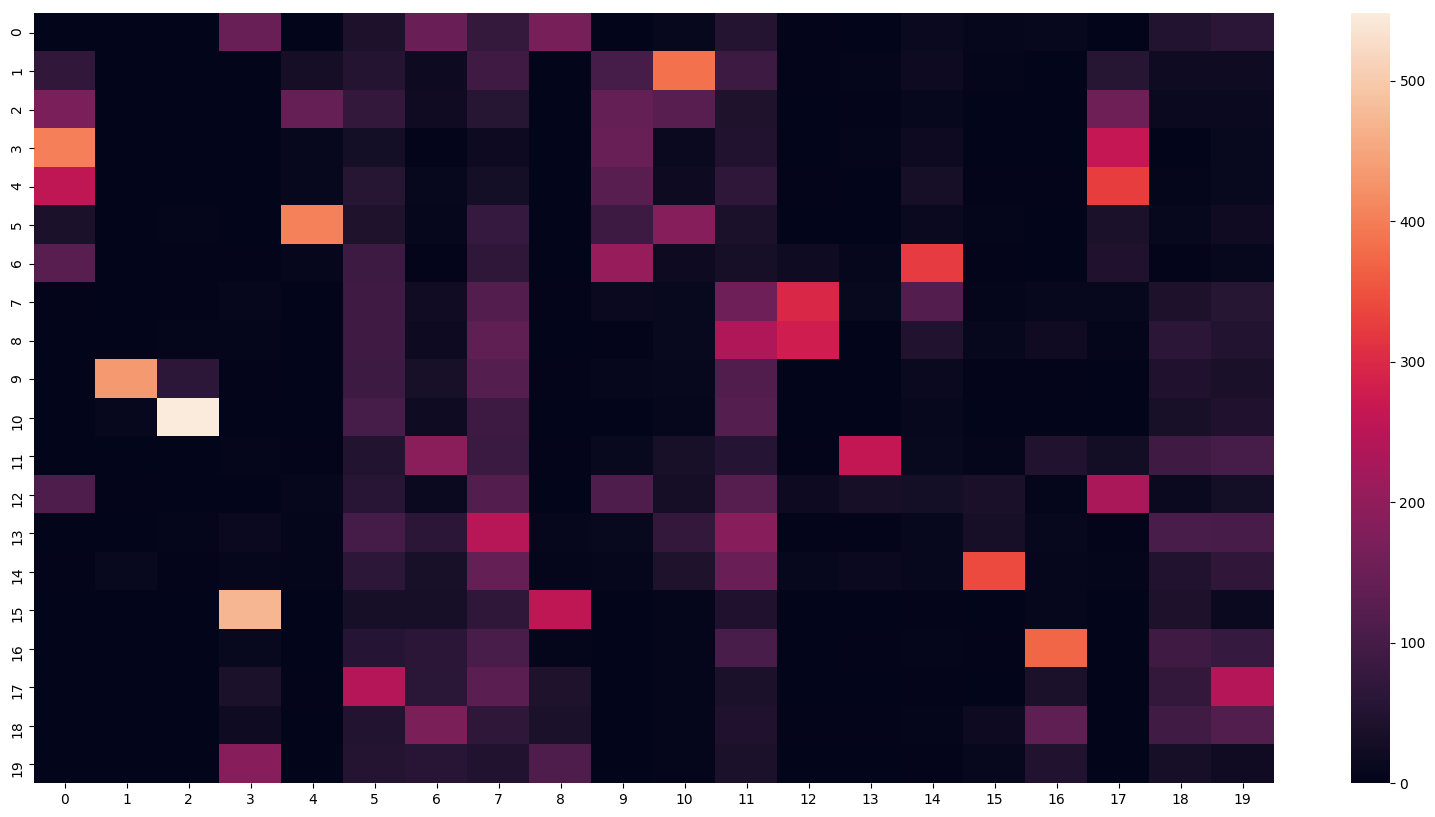

In [81]:
confusion_mat_all = get_confusion_mat(predict_category_all, data_category)
plot_confusion(confusion_mat_all)

In [82]:
print("The precision of the classification is: " + str(get_precision(confusion_mat_all)))

print("The recall of the classification is: " + str(get_recall(confusion_mat_all)))

The precision of the classification is: 0.3347659980897803
The recall of the classification is: 0.3326965934415791


### Summary
In all, if a unlabeled dataset is large enough, we can use topic model to do brief classification. The result might not be that good, but it is enough for unknown dataset, especifically multiclass dataset. 

## Classifying labeled data
If we have a labeled dataset, we can also use topic model to improve the classification accuracy. <br>
Here I use SVM linear kernel to train a model. Divide the whole dataset into training and testing part. Use the topic model to build the feature just as we did in [Classifying unlabeled data](#Classifying-unlabeled-data). And then get the confusion matrix as well as the precision and recall.<br>
We can see from the result that both the precision and the recall get improved significantly. The nearly 50% accuracy is pretty good for the 20 multiclasses classification.  

In [84]:
# training a linear SVM classifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(feature_all, data_category, random_state = 0)

svm_model_linear = SVC(kernel = 'linear', C = 1).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)
 
# creating a confusion matrix
cm = confusion_matrix(y_test, svm_predictions)

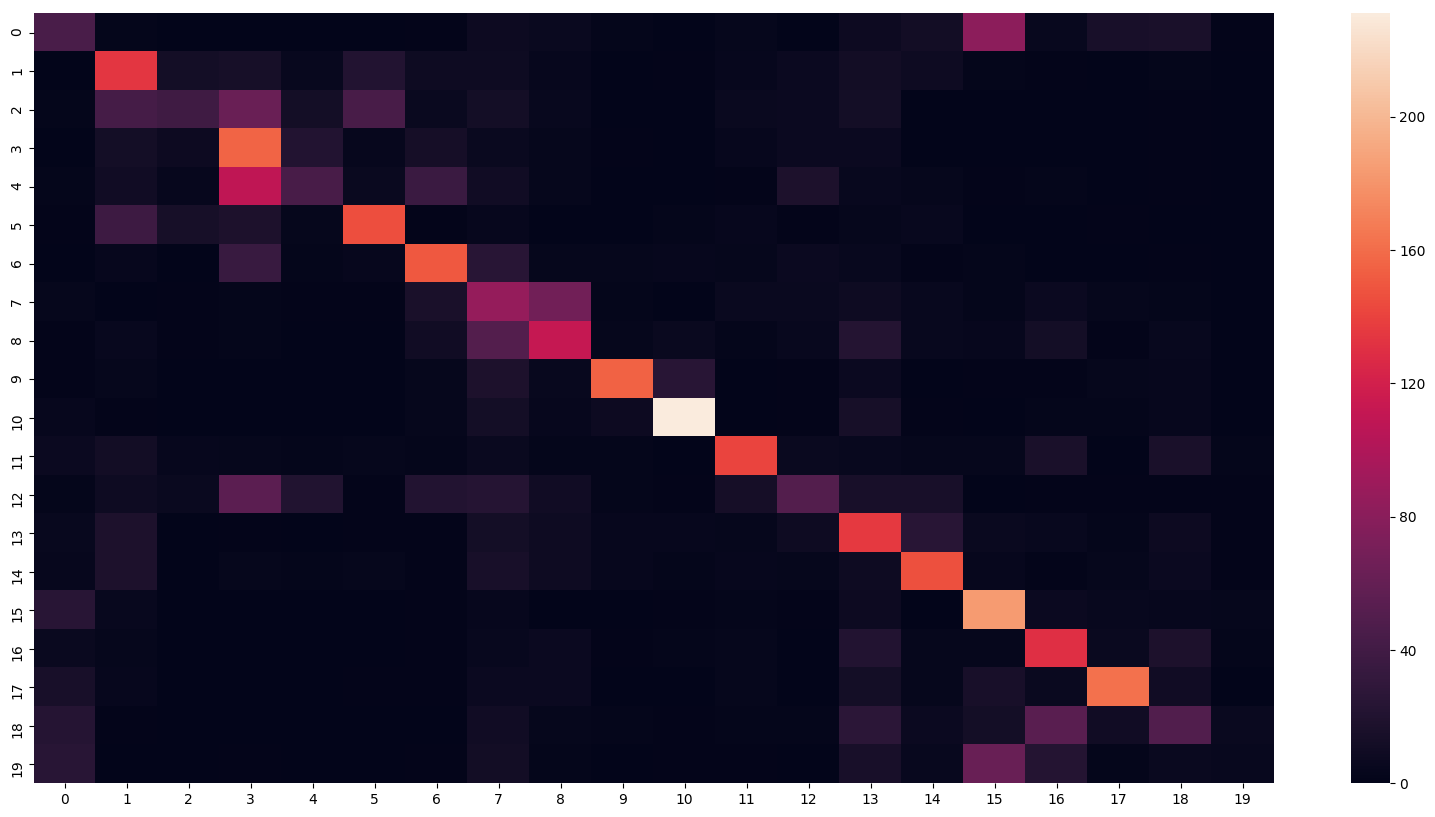

In [86]:
plot_confusion(cm)

In [87]:
print("The precision of the classification is: " + str(get_precision(cm)))

print("The recall of the classification is: " + str(get_recall(cm)))

The precision of the classification is: 0.4885398981324278
The recall of the classification is: 0.5294991511035654


## Conclusion

Through this tutorial, you should know some usages of topic model. After generating a topic model for an unknown dataset, you can find its structure. You can also do classification for these unlabeled dataset with the help of topic model. You can even improve the accuracy of the classificaiton of labeled dataset by applying topic model. <br>
While presenting the result of topic models, we use a lot of visualization methods, which can be pretty helpful if you want to show your topic model to others.

## Reference

This tutorial's reference is listed as below:
+ [Topic Models in Gensim](https://radimrehurek.com/gensim/wiki.html)
+ [Text Analysis with Topic Models](https://de.dariah.eu/tatom/index.html)
+ [The 20 newsgroups text dataset](http://scikit-learn.org/stable/datasets/twenty_newsgroups.html)
+ [Plot confusion matrix using seabron](https://seaborn.pydata.org/generated/seaborn.heatmap.html)